# Fourier Transforms and Analysis

In the last lecture, we discussed the basics of Fourier Series and looked into computing the coefficients of trigonometric decomposition for a few simple waveforms (square and sawtooth). 

Today, we will make the connections between Fourier Series and Fourier Transforms, discuss and evaluate the Discrete and Fast Fourier Tranforms (DFT and FFT, respectively), and look at a few applications in context.

Table of Contents
1. [History](#History)
1. [Square wave](#square-wave)
   1. [Boilerplate stuff](#Boilerplate-stuff)
   1. [Coding the Fourier Series](#Coding-the-Fourier-Series)
   1. [Plotting the SquareFourier series](#Plotting-the-SquareFourier-series)
1. [Fourier transforms](#Fourier-transforms)

## History

Fourier was actually investigating the Heat Equation (see your HW\#5) when he developed the revolutionary approach that now bears his name.

From [Wikipedia](https://en.wikipedia.org/wiki/Joseph_Fourier):

> In 1822 Fourier published his work on heat flow in Théorie analytique de la chaleur (The Analytical Theory of Heat), in which he based his reasoning on Newton's law of cooling, namely, that the flow of heat between two adjacent molecules is proportional to the extremely small difference of their temperatures.

He determined that the solution can be expanded in terms of sines and cosines:

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n \cos(nx) + b_n \sin(nx)
$$


## Square wave

Let's use our result from last time to look at this in more detail:

$$
a_n =\frac{2}{n\pi}\sin \left(n \omega_0 \frac{\pi}{2} \right)
$$

What we want is the equivalent of the following:

In [74]:
from IPython.display import Image
Image(url='Fourier_Transform.gif')  

---
# DISCUSSION

1. How many terms will we need to accurately approximate the square wave that we discussed last time?

---

### Boilerplate stuff

To find out, let's first load the libraries as usual

In [97]:
%matplotlib inline
import numpy as np
import scipy.signal as signal    # Notice this one is new!
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from mpl_toolkits.mplot3d import Axes3D
import math
import cmath

And define some useful variables

In [70]:
pi = np.pi
x  = np.linspace(-4*pi, 4*pi, 1000)

### Coding the Fourier Series

Now, let's adapt the "Fourier Function" that we had before for the sawtooth wave, but now for the square wave:

Recall, that we determined that the __sawtooth wave__ Fourier Series looks like this:

$$
\begin{align}
s(x)&={\frac {a_{0}}{2}}+\sum _{m=1}^{\infty }\left[a_{m}\cos \left(mx\right)+b_{n}\sin \left(mx\right)\right]\\
&={\frac {2}{\pi }}\sum _{m=1}^{\infty }{\frac {(-1)^{m+1}}{m}}\sin(mx),\quad \mathrm {for} \quad x-\pi \notin 2\pi \mathbf {Z} 
\end{align}
$$

In [71]:
def SawtoothFourier(M,T,t):                  # M = number waves, T = period, t = time
    sumy  = 0                                # initialize the output                 
    omega = 2.*np.pi/T                       # Omega = 2pi/T
    sign  = 1                                # Sign of the coefficient                                     
    for m in range(1,M):                     # Number of terms to include
        sumy += (sign/m) * np.sin(m*omega*t) # value of the function after adding next term                     
        sign = -sign                         # swap the sign of the coefficient    
    sumy = (2.0/np.pi)*sumy                  # Common factor in front of the sum
    return sumy

--- 
# DISCUSSION

1. Code up your own `SquareFourier` based on this example
1. How many terms do we need to get the same picture as from Wikipedia?
---

In [76]:
def SquareFourier(M,T,t):                                         # M = number modes to include, T = period, t = time
    sumy  = 0                                                     # initialize the output                 
    omega = 2.*pi/T                                               # Omega = 2pi/T
    for m in range(1,M,2):                                        # Loop over only odd modes
        coeff = (2./(m*pi))*np.sin(m*pi/2.)
        sumy += coeff*np.cos(m*omega*x)                           # value of the function after adding next term   
    sumy += 0.5
    return sumy

### Plotting the SquareFourier series

We can reuse basically everything from before|

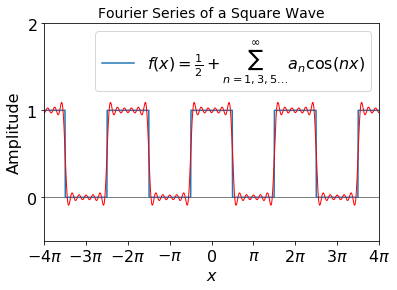

In [75]:
plt.axhline(0, color='gray', lw=1)

f = 0.5 + 0.5 * signal.square(x + pi/2)

plt.plot(x, f, lw=1.5, label=r'$f(x)=\frac{1}{2} + \sum_{n=1,3,5\ldots}^{\infty}a_n \cos(nx)$')

s = SquareFourier(12, 2*pi, x)   
lines, = plt.plot(x, s, lw=1, color='red')

plt.yticks([-1, 0, 1, 2], ['$-1$', '$0$', '$1$', '$2$'])
plt.xticks([-4*pi, -3*pi, -2*pi, -1*pi, 0, pi, 2*pi, 3*pi, 4*pi], ['$-4\pi$', '$-3\pi$', '$-2\pi$', '$-\pi$', '$0$', '$\pi$', '$2\pi$', '$3\pi$', '$4\pi$'])
plt.xlim(-4*pi, 4*pi)
plt.ylim(-0.5, 2)
plt.rcParams.update({'font.size': 16})
plt.title('Fourier Series of a Square Wave', fontsize=14)
plt.xlabel('$x$')
plt.ylabel('Amplitude')
plt.legend(fontsize=16, fancybox=True, loc='best')
plt.show()

## Fourier transforms

Let's take what we discussed and use it!

Let's test it out

$$
y_k = \sin(2\pi f k/N)
$$

In [105]:
def fft(data):

    N = len(data)
    if N < 1:               # transform is trivial
        return [data[0]]

    even = fft(data[0::2])
    odd  = fft(data[1::2])
    
    part1 = [even[k] + exp(-2j*pi*k/N)*odd[k] for k in range(N/2)]
    part2 = [even[k] - exp(-2j*pi*k/N)*odd[k] for k in range(N/2)]
    return part1 + part2

In [111]:
import math
N = 512
f = 10

x = np.array([float(i) for i in range(N)])
y = np.array( [math.sin(-2*pi*f*xi / float(N)) for xi in x] )

Y = fft(y)

Yre = [math.sqrt(Y[i].real**2 + Y[i].imag**2) for i in range(N)]
plt.plot(x,y)

RecursionError: maximum recursion depth exceeded in comparison

In [90]:
def SolvePoisson(Vinitial, rho, numxbins, numybins, epsilon = 1e-5, imax = 1000):

    ## Initialize the grid with the argument
    V   = Vinitial

    ## Store previous grid values to check against error tolerance
    Vnext = V + np.zeros((numxbins+1, numybins+1))
    error = Vnext - V

    ## Constants
    k = 1          ## k is just is a counter

    ## Iterative procedure
    while k <= imax:
 
        # Iterate over the two dimensional space
        for i in np.arange(1, numxbins):

            for j in np.arange(1,  numybins):

                # Calculate the new value of the potential at this point
                # and the difference with respect to the previous value
                ##   --> what are we missing here?
                Vnext[i,j] = (V[i-1,j] + V[i+1,j] + V[i,j-1] + V[i,j+1] - rho[i,j])/4.
                error[i,j] = np.abs(Vnext[i,j] - V[i,j])

        # Set the potential to the newly calculated value and increment the counter
        V = Vnext + np.zeros((numxbins+1, numybins+1))
        k += 1
        
        # Update the maximum error across the mesh
        errmax = np.max(np.max(error))

        # Determine if the maximum error across the mesh is smaller than the specified 
        # tolerance
        if errmax < epsilon:

            print("Convergence after ", k, " iterations.")
            return V

    print("No convergence after ", k, " iterations.")
    return False

In [91]:
def PlotSolution(numxbins,numybins,stepsize,V):

    ## Set up x and y vectors for meshgrid
    x = np.linspace(0, numxbins * stepsize, numxbins+1)
    y = np.linspace(0, numybins * stepsize, numybins+1)

    # set up a figure that is wider than it is tall since we want the figures
    # to be side by side
    figure = plt.figure(figsize=(20,8))
    
    # My colormap: see https://matplotlib.org/users/colormaps.html
    # mycmap = colormap.viridis
    mycmap = colormap.plasma
    # mycmap = colormap.inferno
    # mycmap = colormap.magma
    
    
    # set up the axes for the first plot
    ax = figure.add_subplot(1, 2, 1, projection='3d')
    X,Y  = np.meshgrid(x,y)
    surf = ax.plot_surface(X, Y, V.transpose(), cmap=mycmap, linewidth=0, antialiased=False)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("V(x,y)")

    # set up the axes for the second plot
    ax = figure.add_subplot(1, 2, 2)
    cs   = plt.contourf(X, Y, V.transpose(), 32, cmap=mycmap)
    cbar = plt.colorbar()
    cbar.set_label('V(x,y)')
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

In [93]:
## Size of plate and mesh
numxbins = 32
numybins = 32
stepsize = 1./128.

## Set boundary conditions for the problem
Vboundary             = np.zeros((numxbins+1, numybins+1))
Vboundary[0,:]        = 50  ## XMin Boundary
Vboundary[numxbins,:] = 50  ## XMax Boundary
Vboundary[:,0]        = -10 ## YMin Boundary
Vboundary[:,numybins] = 10  ## YMax Boundary

## Set the source term
rho = np.zeros((numxbins+1, numybins+1))
rho[int(numxbins / 4)     , int(numybins / 4)]     =  100
rho[int(3 * numxbins / 4) , int(3 * numybins / 4)] = -250

## Tolerance and failsafe
epsilon = 1e-3     ## Absolute Error tolerance
imax    = 10000    ## Maximum number of iterations allowed


In [94]:
## Calculate the scalar function V
V = SolvePoisson(Vboundary, rho, numxbins, numybins, epsilon, imax)

Convergence after  1211  iterations.


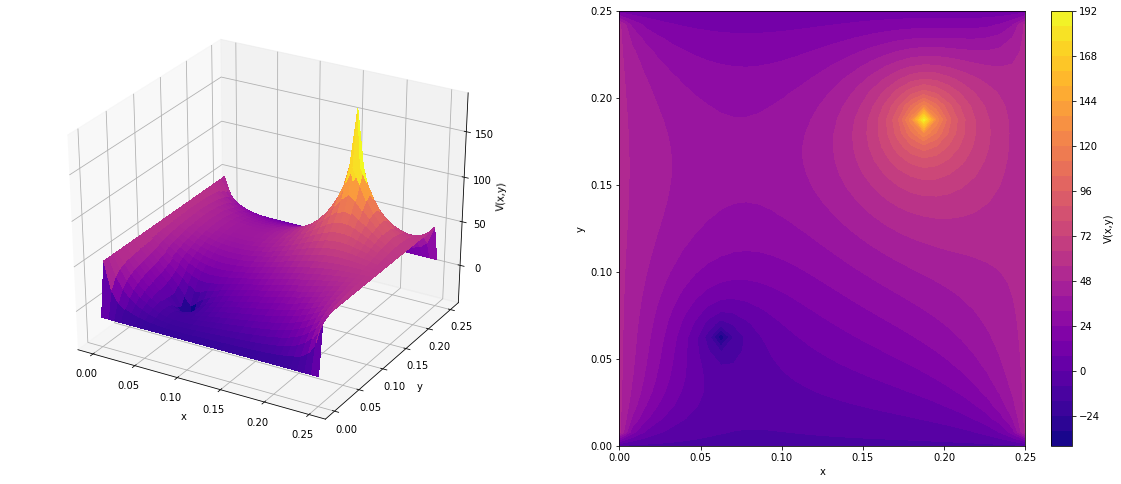

In [95]:
## Plot V
PlotSolution(numxbins, numybins, stepsize, V)
plt.show()

In [98]:


def Matrix(rows, cols, initial_value=0.0):
    """ Constructs new matrix with specified number of rows and col(umn)s.
        The matrix elements are initialized to initial_value
    """
    m = []
    for row in range(rows):
        m.append([initial_value for col in range(cols)])
    return m

def dft(data, inverse=False):
    """Return Discrete Fourier Transform (DFT) of a complex data vector"""
    N = len(data)
    transform = [ 0 ] * N
    for k in range(N):
        for j in range(N):
            angle = 2 * math.pi * k * j / float(N)
            if inverse:
                angle = -angle
            transform[k] += data[j] * cmath.exp(1j * angle)
    if inverse:
        for k in range(N):
            transform[k] /= float(N)
    return transform


def fft(data, inverse=False):
    """Return Fast Fourier Transform (FFT) using Danielson-Lanczos Lemma"""
    N = len(data)
    if N == 1:               # transform is trivial
        return [data[0]]
    elif N % 2 == 1:         # N is odd, lemma does not apply
        return dft(data, inverse)
    # perform even-odd decomposition and transform recursively
    even = fft([data[2*j] for j in range(N//2)], inverse)
    odd  = fft([data[2*j+1] for j in range(N//2)], inverse)
    W = cmath.exp(1j * 2 * math.pi / N)
    if inverse:
        W = 1.0 / W
    Wk = 1.0
    transform = [ 0 ] * N
    for k in range(N):
        transform[k] = even[k % (N//2)] + Wk * odd[k % (N//2)]
        Wk *= W
    if inverse:
        for k in range(N):
            transform[k] /= 2.0
    return transform

N = numxbins

# FFT rows of rho
f = [ 0.0 ] * N                 # to store rows and columns
for j in range(N):
    for k in range(N):
        f[k] = rho[j][k]
    f = fft(f)
    for k in range(N):
        rho[j][k] = f[k]

# FFT columns of rho
for k in range(N):
    for j in range(N):
        f[j] = rho[j][k]
    f = fft(f)
    for j in range(N):
        rho[j][k] = f[j]

# Solve equation in Fourier space
V = Matrix(N, N)
W = cmath.exp(1.0j * 2 * math.pi / N)
Wm = Wn = 1.0 + 0.0j
for m in range(N):
    for n in range(N):
        denom = 4.0 - Wm - 1 / Wm - Wn - 1 / Wn
        if abs(denom) != 0.0:
            V[m][n] = rho[m][n] * h**2 / denom
        Wn *= W
    Wm *= W

# Inverse FFT rows of V
need_inverse = True             # to store rows and columns
for j in range(N):
    for k in range(N):
        f[k] = V[j][k]
    f = fft(f, need_inverse)
    for k in range(N):
        V[j][k] = f[k]

# Inverse FFT columns of V
for k in range(N):
    for j in range(N):
        f[j] = V[j][k]
    f = fft(f, need_inverse)
    for j in range(N):
        V[j][k] = f[j]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


NameError: name 'h' is not defined